# Vaccine tweets - processing and exploration

In [1]:
# standard packages
import numpy as np
import pandas as pd

# visualization packages
import matplotlib
%matplotlib inline
import seaborn as sns; sns.set_style('ticks')
from wordcloud import WordCloud

# text processing/nlp packages
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from gensim.matutils import Sparse2Corpus
from gensim.models import LdaModel
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import stats
from scipy.sparse import csr_matrix
import statsmodels.api as sm 
from collections import Counter

# saving/loading packages
import gzip
import pickle

# custom functions and reload after editing
from functions import *
%load_ext autoreload
%autoreload 2

# ignore sklearn warnings
# (code from: https://stackoverflow.com/questions/32612180/eliminating-warnings-from-scikit-learn)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# increase column width to more easily read tweets
pd.set_option('max_colwidth', 150)

## Prepare the data

In [ ]:
# load file
df = pd.read_csv('tweets_clean.csv', index_col=0)

# check shape
df.shape

In [4]:
df['date'].unique()

array(['2021-01-03', '2021-01-02',
       "['misleadingnews', 'california', 'pfizer', 'misbar', 'news', 'factcheck', 'facts', 'breakingnews', 'covid19']",
       "['suspiciousnews', 'misbar', 'news', 'factcheck', 'facts', 'covid19']",
       '2021-01-01', '2020-12-31', '[]', '2020-12-30', '2020-12-29',
       '2020-12-28', '2020-12-27', '2020-12-26', '2020-12-25',
       '2020-12-24', '2020-12-23', '2020-12-22', '2020-12-21',
       '2020-12-20', '2020-12-19', '2020-12-18', '2020-12-17',
       '2020-12-16', '2020-12-15', '2020-12-14', '2020-12-13',
       '2020-12-12', '2020-12-11', '2020-12-10', '2020-12-09',
       '2020-12-08', '2020-12-07', '2020-12-06', '2020-12-05',
       '2020-12-04', '2020-12-03', '2020-12-02', '2020-12-01',
       '2020-11-30', '2020-11-29', '2020-11-28', '2020-11-27',
       '2020-11-26', '2020-11-25', '2020-11-24', '2020-11-23',
       '2020-11-22', '2020-11-21', '2020-11-20', '2020-11-19',
       '2020-11-18', '2020-11-17', '2020-11-16', '2020-11-15',
   

##### Do some additional cleaning

In [5]:
df=df[df.date != "['misleadingnews', 'california', 'pfizer', 'misbar', 'news', 'factcheck', 'facts', 'breakingnews', 'covid19']"]
df=df[df.date != "['suspiciousnews', 'misbar', 'news', 'factcheck', 'facts', 'covid19']"]
df=df[df.date !=  "['itinthed373']"]
df=df[df.date !=  '[]']
df['date'].unique()

array(['2021-01-03', '2021-01-02', '2021-01-01', '2020-12-31',
       '2020-12-30', '2020-12-29', '2020-12-28', '2020-12-27',
       '2020-12-26', '2020-12-25', '2020-12-24', '2020-12-23',
       '2020-12-22', '2020-12-21', '2020-12-20', '2020-12-19',
       '2020-12-18', '2020-12-17', '2020-12-16', '2020-12-15',
       '2020-12-14', '2020-12-13', '2020-12-12', '2020-12-11',
       '2020-12-10', '2020-12-09', '2020-12-08', '2020-12-07',
       '2020-12-06', '2020-12-05', '2020-12-04', '2020-12-03',
       '2020-12-02', '2020-12-01', '2020-11-30', '2020-11-29',
       '2020-11-28', '2020-11-27', '2020-11-26', '2020-11-25',
       '2020-11-24', '2020-11-23', '2020-11-22', '2020-11-21',
       '2020-11-20', '2020-11-19', '2020-11-18', '2020-11-17',
       '2020-11-16', '2020-11-15', '2020-11-14', '2020-11-13',
       '2020-11-12', '2020-11-11', '2020-11-10', '2020-11-09', nan,
       '2020-11-08', '2020-11-07', '2020-11-06', '2020-11-05',
       '2020-11-04', '2020-11-03', '2020-11-02', '

In [6]:
# drop a nan value
df.dropna(how='all', inplace=True)

In [7]:
df['date'].unique()

array(['2021-01-03', '2021-01-02', '2021-01-01', '2020-12-31',
       '2020-12-30', '2020-12-29', '2020-12-28', '2020-12-27',
       '2020-12-26', '2020-12-25', '2020-12-24', '2020-12-23',
       '2020-12-22', '2020-12-21', '2020-12-20', '2020-12-19',
       '2020-12-18', '2020-12-17', '2020-12-16', '2020-12-15',
       '2020-12-14', '2020-12-13', '2020-12-12', '2020-12-11',
       '2020-12-10', '2020-12-09', '2020-12-08', '2020-12-07',
       '2020-12-06', '2020-12-05', '2020-12-04', '2020-12-03',
       '2020-12-02', '2020-12-01', '2020-11-30', '2020-11-29',
       '2020-11-28', '2020-11-27', '2020-11-26', '2020-11-25',
       '2020-11-24', '2020-11-23', '2020-11-22', '2020-11-21',
       '2020-11-20', '2020-11-19', '2020-11-18', '2020-11-17',
       '2020-11-16', '2020-11-15', '2020-11-14', '2020-11-13',
       '2020-11-12', '2020-11-11', '2020-11-10', '2020-11-09',
       '2020-11-08', '2020-11-07', '2020-11-06', '2020-11-05',
       '2020-11-04', '2020-11-03', '2020-11-02', '2020-

In [8]:
# convert date column to datetime
df['date'] = df.date.astype('datetime64[ns]')

# check shape
df.shape

(415228, 15)

In [9]:
df['date'].describe()
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.to_datetime(df['date']).dt.to_period('D')
df['month_year'] = pd.to_datetime(df['date']).dt.to_period('M')

In [20]:
df.head()

,date,username,tweet,replies_count,retweets_count,likes_count,hashtags,link,year,month,day,month_year
0,2021-01-03,albertosmagus18,@TheMossadIL @JoBiGutenburg02 @guardian Here we go again with the usual retinue of bad mouthing Israel N the usual venom spewing of baseless accus...,0.0,0.0,0.0,[],https://twitter.com/albertosmagus18/status/1345882628222832641,2021,1,2021-01-03,2021-01
1,2021-01-03,bbb1022,A friend of mine got her Mederna vaccine last Thursday. Sore arm is the worst thing. Works dietary in a state hospital. 🤞🤞🤞🤞,0.0,1.0,6.0,[],https://twitter.com/BBB1022/status/1345882621188972545,2021,1,2021-01-03,2021-01
2,2021-01-03,ladysta86772923,"@BeschlossDC @redtaz1951 Trump never cared about our Democracy or civilization just raw power, he would give the vaccine only to his rich friends ...",0.0,0.0,1.0,['wearamasksavealife'],https://twitter.com/LadySta86772923/status/1345882590520066048,2021,1,2021-01-03,2021-01
3,2021-01-03,uksophie1,@kristie_lauraaa @TTamharl We have never had a flu vaccine. It’s a shot to inhibit symptoms. Problem is they have missed the strain for past years.,0.0,0.0,0.0,[],https://twitter.com/uksophie1/status/1345882553421586432,2021,1,2021-01-03,2021-01
4,2021-01-03,dianerocks52,Tennessee officials give COVID vaccine to 'close family and friends' after denying it to 75-year-olds: report https://t.co/533yhOjyOu,0.0,0.0,0.0,[],https://twitter.com/dianerocks52/status/1345882526389137408,2021,1,2021-01-03,2021-01


In [11]:
cols = list(df.columns.values)


In [12]:
cols

['id',
 'conversation_id',
 'created_at',
 'date',
 'user_id',
 'username',
 'name',
 'tweet',
 'replies_count',
 'retweets_count',
 'likes_count',
 'hashtags',
 'link',
 'retweet',
 'reply_to',
 'year',
 'month',
 'day',
 'month_year']

In [13]:
# drop columns we know we won't need for this project
df.drop(columns=['id', 'conversation_id', 'created_at',  'user_id', 'name',
                 'retweet',  'reply_to'], inplace=True)

# confirm
df.head()

,date,username,tweet,replies_count,retweets_count,likes_count,hashtags,link,year,month,day,month_year
0,2021-01-03,albertosmagus18,@TheMossadIL @JoBiGutenburg02 @guardian Here we go again with the usual retinue of bad mouthing Israel N the usual venom spewing of baseless accus...,0.0,0.0,0.0,[],https://twitter.com/albertosmagus18/status/1345882628222832641,2021,1,2021-01-03,2021-01
1,2021-01-03,bbb1022,A friend of mine got her Mederna vaccine last Thursday. Sore arm is the worst thing. Works dietary in a state hospital. 🤞🤞🤞🤞,0.0,1.0,6.0,[],https://twitter.com/BBB1022/status/1345882621188972545,2021,1,2021-01-03,2021-01
2,2021-01-03,ladysta86772923,"@BeschlossDC @redtaz1951 Trump never cared about our Democracy or civilization just raw power, he would give the vaccine only to his rich friends ...",0.0,0.0,1.0,['wearamasksavealife'],https://twitter.com/LadySta86772923/status/1345882590520066048,2021,1,2021-01-03,2021-01
3,2021-01-03,uksophie1,@kristie_lauraaa @TTamharl We have never had a flu vaccine. It’s a shot to inhibit symptoms. Problem is they have missed the strain for past years.,0.0,0.0,0.0,[],https://twitter.com/uksophie1/status/1345882553421586432,2021,1,2021-01-03,2021-01
4,2021-01-03,dianerocks52,Tennessee officials give COVID vaccine to 'close family and friends' after denying it to 75-year-olds: report https://t.co/533yhOjyOu,0.0,0.0,0.0,[],https://twitter.com/dianerocks52/status/1345882526389137408,2021,1,2021-01-03,2021-01


## Analyze sentiment using VADER

In [21]:
%%time

# instantiate vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# create a column with the compound polarity score
df['sentiment_score'] = df['tweet'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

CPU times: user 48.3 s, sys: 191 ms, total: 48.5 s
Wall time: 48.5 s


In [22]:

# turn this into our target classes: negative, positive, and neutral
conditions = [
    df.sentiment_score >= .05,
    df.sentiment_score <= -.05
]

choices = [
    'positive',
    'negative'
]

df['sentiment'] = np.select(conditions, choices, 'neutral')

In [23]:
df

,date,username,tweet,replies_count,retweets_count,likes_count,hashtags,link,year,month,day,month_year,sentiment_score,sentiment
0,2021-01-03,albertosmagus18,@TheMossadIL @JoBiGutenburg02 @guardian Here we go again with the usual retinue of bad mouthing Israel N the usual venom spewing of baseless accus...,0.0,0.0,0.0,[],https://twitter.com/albertosmagus18/status/1345882628222832641,2021,1,2021-01-03,2021-01,-0.7717,negative
1,2021-01-03,bbb1022,A friend of mine got her Mederna vaccine last Thursday. Sore arm is the worst thing. Works dietary in a state hospital. 🤞🤞🤞🤞,0.0,1.0,6.0,[],https://twitter.com/BBB1022/status/1345882621188972545,2021,1,2021-01-03,2021-01,-0.5267,negative
2,2021-01-03,ladysta86772923,"@BeschlossDC @redtaz1951 Trump never cared about our Democracy or civilization just raw power, he would give the vaccine only to his rich friends ...",0.0,0.0,1.0,['wearamasksavealife'],https://twitter.com/LadySta86772923/status/1345882590520066048,2021,1,2021-01-03,2021-01,0.8614,positive
3,2021-01-03,uksophie1,@kristie_lauraaa @TTamharl We have never had a flu vaccine. It’s a shot to inhibit symptoms. Problem is they have missed the strain for past years.,0.0,0.0,0.0,[],https://twitter.com/uksophie1/status/1345882553421586432,2021,1,2021-01-03,2021-01,-0.6722,negative
4,2021-01-03,dianerocks52,Tennessee officials give COVID vaccine to 'close family and friends' after denying it to 75-year-olds: report https://t.co/533yhOjyOu,0.0,0.0,0.0,[],https://twitter.com/dianerocks52/status/1345882526389137408,2021,1,2021-01-03,2021-01,0.1779,positive
5,2021-01-03,wildcated1979,"@sdr_medco @RENEEWEATHERS2 When that 40% gets down to 30%, they will start taking it. Need to mandate that you can’t get into restaurants, bars w...",0.0,0.0,0.0,[],https://twitter.com/WildcatEd1979/status/1345882521339375616,2021,1,2021-01-03,2021-01,0.0000,neutral
6,2021-01-03,warrenrichman,@Chizack @Scripteladora @DanielD86829949 @P3ng1z @HebMacMan @TelAvivbroker @TheZionist3 @ErezNeumark @Michael__Baskin @malkaavram @siobanvict @yaa...,0.0,1.0,3.0,[],https://twitter.com/WarrenRichman/status/1345882519305121794,2021,1,2021-01-03,2021-01,-0.8885,negative
7,2021-01-03,_serenaaaaa_,My dad got the Covid vaccine 🥴,0.0,0.0,0.0,[],https://twitter.com/_Serenaaaaa_/status/1345882517266595840,2021,1,2021-01-03,2021-01,0.0000,neutral
8,2021-01-03,leslieridle,@lelakis @degaeta I would hope she’s busy today working with the Dept of HSS to cobble together a message to all retirees and state employees abou...,2.0,0.0,12.0,[],https://twitter.com/leslieridle/status/1345882506164228096,2021,1,2021-01-03,2021-01,0.4404,positive
9,2021-01-03,allegraehobbs,"@gabydvj the genius of sandwiching ""I'm not taking the COVID vaccine"" between those two sentiments....what a rollercoaster",0.0,0.0,10.0,[],https://twitter.com/AllegraEHobbs/status/1345882505891741698,2021,1,2021-01-03,2021-01,0.0000,neutral


In [24]:
df.sentiment.value_counts()

positive    153288
negative    131535
neutral     130405
Name: sentiment, dtype: int64

In [25]:
df.sentiment.value_counts(normalize=True)

positive    0.369166
negative    0.316778
neutral     0.314056
Name: sentiment, dtype: float64

## Normalize corpus

In [2]:
import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from contractions import CONTRACTION_MAP
import unicodedata
from bs4 import BeautifulSoup

nlp = spacy.load('en', parse=True, tag=True, entity=True)
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, #entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

#### Build functions to include in the normalizer

In [3]:
# 1. Remove html tags
def strip_html_tags(text):
    soup=BeautifulSoup(text,"html.parser")
    stripped_text=soup.get_text()
    return stripped_text
strip_html_tags('<html><h2>Some important text</h2></html>')

# 2. Remove accents
def remove_accented_chars(text):    
    text=unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text
remove_accented_chars('Sómê Áccèntéd téxt')

# 3. Expand contractions
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text
expand_contractions("Y'all can't expand contractions I'd think")

# 4. Remove special characters
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, ' ', text)
    return text
remove_special_characters("Well this was fun! What do you think? 123#@!", 
                          remove_digits=True)

# 5. Lemmatization
def lemmatize_text(text):
    text=nlp(text)
    text=' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text
lemmatize_text('My system keeps crashing! his crashed yesterday, ours crashes daily')

# 6. Stemming
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

# 7. Remove stopwords
def remove_stopwords(text, is_lowercase=False):
    tokens=tokenizer.tokenize(text)
    tokens=[token.strip() for token in tokens]
    if is_lowercase:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens=[token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
remove_stopwords("The, and, if are stopwords, computer is not")


', , stopwords , computer not'

#### Build normalizer: put all functions together 

In [4]:
# Turn on functions as desired
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    # Run normalizer on corpus
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

#### Normalize corpus

In [30]:
df.head()

,date,username,tweet,replies_count,retweets_count,likes_count,hashtags,link,year,month,day,month_year,sentiment_score,sentiment
0,2021-01-03,albertosmagus18,@TheMossadIL @JoBiGutenburg02 @guardian Here we go again with the usual retinue of bad mouthing Israel N the usual venom spewing of baseless accus...,0.0,0.0,0.0,[],https://twitter.com/albertosmagus18/status/1345882628222832641,2021,1,2021-01-03,2021-01,-0.7717,negative
1,2021-01-03,bbb1022,A friend of mine got her Mederna vaccine last Thursday. Sore arm is the worst thing. Works dietary in a state hospital. 🤞🤞🤞🤞,0.0,1.0,6.0,[],https://twitter.com/BBB1022/status/1345882621188972545,2021,1,2021-01-03,2021-01,-0.5267,negative
2,2021-01-03,ladysta86772923,"@BeschlossDC @redtaz1951 Trump never cared about our Democracy or civilization just raw power, he would give the vaccine only to his rich friends ...",0.0,0.0,1.0,['wearamasksavealife'],https://twitter.com/LadySta86772923/status/1345882590520066048,2021,1,2021-01-03,2021-01,0.8614,positive
3,2021-01-03,uksophie1,@kristie_lauraaa @TTamharl We have never had a flu vaccine. It’s a shot to inhibit symptoms. Problem is they have missed the strain for past years.,0.0,0.0,0.0,[],https://twitter.com/uksophie1/status/1345882553421586432,2021,1,2021-01-03,2021-01,-0.6722,negative
4,2021-01-03,dianerocks52,Tennessee officials give COVID vaccine to 'close family and friends' after denying it to 75-year-olds: report https://t.co/533yhOjyOu,0.0,0.0,0.0,[],https://twitter.com/dianerocks52/status/1345882526389137408,2021,1,2021-01-03,2021-01,0.1779,positive


In [31]:
corpus = df[['date','year','month', 'month_year', 'tweet', 'sentiment_score', 'sentiment']]

In [32]:
corpus['tweet_clean'] = normalize_corpus(corpus['tweet'])

In [35]:
# save to csv
corpus.to_csv('tweets_clean_normalized.csv')

In [5]:
corpus = pd.read_csv('tweets_clean_normalized.csv', index_col=0)

In [6]:
norm_corpus = list(corpus['tweet_clean'])
norm_corpus

['themossadil jobigutenburg guardian go usual retinue bad mouthing israel n usual venom spew baseless accusation israel responsible corrupt pa occupier sit pile cash steal international donor rather buy vaccine populace occupy',
 'friend mine get mederna vaccine last thursday sore arm bad thing work dietary state hospital',
 'beschlossdc redtaz trump never care democracy civilization raw power would give vaccine rich friend watch country turn stand stephen king wearamasksavealife',
 'kristie_lauraaa ttamharl never flu vaccine shot inhibit symptom problem miss strain past year',
 'tennessee official give covid vaccine close family friend deny year old report https co yhojyou',
 'sdr_medco reneeweathers get start take need mandate not get restaurant bar without proof vaccine',
 'chizack scripteladora danield p ng z hebmacman telavivbroker thezionist erezneumark michael__baskin malkaavram siobanvict yaacovba bilmishmish hawarddaniel zico sonof_egypt threeeyedrav n jbarnathan joanker dubba

In [7]:
corpus.head()

,date,year,month,month_year,tweet,sentiment_score,sentiment,tweet_clean
0,2021-01-03,2021,1,2021-01,@TheMossadIL @JoBiGutenburg02 @guardian Here we go again with the usual retinue of bad mouthing Israel N the usual venom spewing of baseless accus...,-0.7717,negative,themossadil jobigutenburg guardian go usual retinue bad mouthing israel n usual venom spew baseless accusation israel responsible corrupt pa occup...
1,2021-01-03,2021,1,2021-01,A friend of mine got her Mederna vaccine last Thursday. Sore arm is the worst thing. Works dietary in a state hospital. 🤞🤞🤞🤞,-0.5267,negative,friend mine get mederna vaccine last thursday sore arm bad thing work dietary state hospital
2,2021-01-03,2021,1,2021-01,"@BeschlossDC @redtaz1951 Trump never cared about our Democracy or civilization just raw power, he would give the vaccine only to his rich friends ...",0.8614,positive,beschlossdc redtaz trump never care democracy civilization raw power would give vaccine rich friend watch country turn stand stephen king wearamas...
3,2021-01-03,2021,1,2021-01,@kristie_lauraaa @TTamharl We have never had a flu vaccine. It’s a shot to inhibit symptoms. Problem is they have missed the strain for past years.,-0.6722,negative,kristie_lauraaa ttamharl never flu vaccine shot inhibit symptom problem miss strain past year
4,2021-01-03,2021,1,2021-01,Tennessee officials give COVID vaccine to 'close family and friends' after denying it to 75-year-olds: report https://t.co/533yhOjyOu,0.1779,positive,tennessee official give covid vaccine close family friend deny year old report https co yhojyou


## Analyze sentiment using Afinn

In [8]:
from afinn import Afinn
af=Afinn()

#compute sentiment scores (polarity) and labels
# sentiment_score_af=[af.score(tweet) for tweet in norm_corpus]
sentiment_score_af = []
for tweet in norm_corpus:
    try:
        sentiment_score_af.append(af.score(tweet))
    except:        
        sentiment_score_af.append(0)
#         print(tweet)
        
sentiment_af=['positive'if score>0
                   else 'negative' if score<0
                       else 'neutral'
                           for score in sentiment_score_af]

In [9]:
#sentiment statistics 
corpus_sent=pd.DataFrame([list(corpus['date']), list(corpus['year']), list(corpus['month']), list(corpus['month_year']),
                          list(corpus['tweet']), list(corpus['tweet_clean']), list(corpus['sentiment_score']), list(corpus['sentiment']),
                          sentiment_score_af, sentiment_af]).T
corpus_sent.columns=['date', 'year', 'month', 'month_year', 'tweet', 'tweet_clean', 'sentiment_score_vad', 'sentiment_vad',
                'sentiment_score_af', 'sentiment_af']


In [10]:
corpus_sent.head(50)

,date,year,month,month_year,tweet,tweet_clean,sentiment_score_vad,sentiment_vad,sentiment_score_af,sentiment_af
0,2021-01-03,2021,1,2021-01,@TheMossadIL @JoBiGutenburg02 @guardian Here we go again with the usual retinue of bad mouthing Israel N the usual venom spewing of baseless accus...,themossadil jobigutenburg guardian go usual retinue bad mouthing israel n usual venom spew baseless accusation israel responsible corrupt pa occup...,-0.7717,negative,-8,negative
1,2021-01-03,2021,1,2021-01,A friend of mine got her Mederna vaccine last Thursday. Sore arm is the worst thing. Works dietary in a state hospital. 🤞🤞🤞🤞,friend mine get mederna vaccine last thursday sore arm bad thing work dietary state hospital,-0.5267,negative,-3,negative
2,2021-01-03,2021,1,2021-01,"@BeschlossDC @redtaz1951 Trump never cared about our Democracy or civilization just raw power, he would give the vaccine only to his rich friends ...",beschlossdc redtaz trump never care democracy civilization raw power would give vaccine rich friend watch country turn stand stephen king wearamas...,0.8614,positive,5,positive
3,2021-01-03,2021,1,2021-01,@kristie_lauraaa @TTamharl We have never had a flu vaccine. It’s a shot to inhibit symptoms. Problem is they have missed the strain for past years.,kristie_lauraaa ttamharl never flu vaccine shot inhibit symptom problem miss strain past year,-0.6722,negative,-7,negative
4,2021-01-03,2021,1,2021-01,Tennessee officials give COVID vaccine to 'close family and friends' after denying it to 75-year-olds: report https://t.co/533yhOjyOu,tennessee official give covid vaccine close family friend deny year old report https co yhojyou,0.1779,positive,-1,negative
5,2021-01-03,2021,1,2021-01,"@sdr_medco @RENEEWEATHERS2 When that 40% gets down to 30%, they will start taking it. Need to mandate that you can’t get into restaurants, bars w...",sdr_medco reneeweathers get start take need mandate not get restaurant bar without proof vaccine,0,neutral,0,neutral
6,2021-01-03,2021,1,2021-01,@Chizack @Scripteladora @DanielD86829949 @P3ng1z @HebMacMan @TelAvivbroker @TheZionist3 @ErezNeumark @Michael__Baskin @malkaavram @siobanvict @yaa...,chizack scripteladora danield p ng z hebmacman telavivbroker thezionist erezneumark michael__baskin malkaavram siobanvict yaacovba bilmishmish haw...,-0.8885,negative,-7,negative
7,2021-01-03,2021,1,2021-01,My dad got the Covid vaccine 🥴,dad get covid vaccine,0,neutral,0,neutral
8,2021-01-03,2021,1,2021-01,@lelakis @degaeta I would hope she’s busy today working with the Dept of HSS to cobble together a message to all retirees and state employees abou...,lelakis degaeta would hope busy today work dept hss cobble together message retiree state employee vaccine go work,0.4404,positive,2,positive
9,2021-01-03,2021,1,2021-01,"@gabydvj the genius of sandwiching ""I'm not taking the COVID vaccine"" between those two sentiments....what a rollercoaster",gabydvj genius sandwich not take covid vaccine two sentiment rollercoaster,0,neutral,0,neutral


In [11]:
corpus_sent['sentiment_score_af']=corpus_sent.sentiment_score_af.astype('float')
corpus_sent['sentiment_score_vad']=corpus_sent.sentiment_score_vad.astype('float')

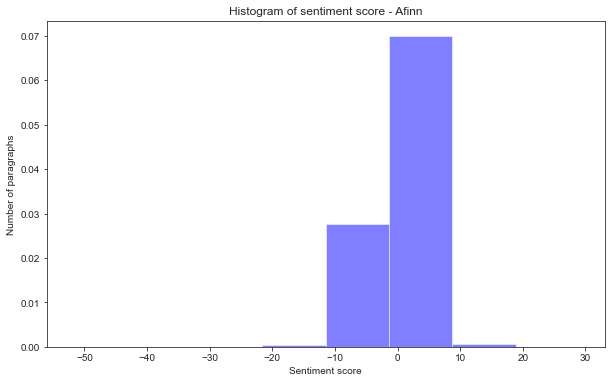

In [12]:
import matplotlib.pyplot as plt
num_bins = 8
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(corpus_sent.sentiment_score_af, num_bins, density=True, facecolor='blue', alpha=0.5)
plt.xlabel('Sentiment score')
plt.ylabel('Number of paragraphs')
plt.title('Histogram of sentiment score - Afinn')
plt.show();

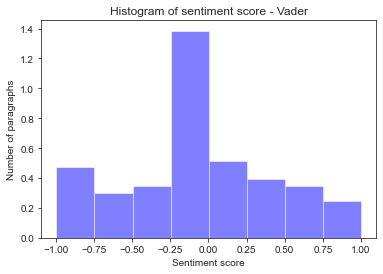

In [13]:
n, bins, patches = plt.hist(corpus_sent.sentiment_score_vad, num_bins, density=True, facecolor='blue', alpha=0.5)
plt.xlabel('Sentiment score')
plt.ylabel('Number of paragraphs')
plt.title('Histogram of sentiment score - Vader')
plt.show();

In [14]:
corpus_sent.to_csv('tweets_clean_sentimentRules.csv')

In [15]:
corpus_sent = pd.read_csv('tweets_clean_sentimentRules.csv', index_col=0)

## Analyze sentiment with ML

### Build a Tweets dataset

In [103]:
import pandas as pd
import matplotlib.pyplot as plt

In [104]:
# Initialize a dataframe for storing tweets
df = pd.DataFrame(columns=['tweet', 'source', 'sentiment'])

##### NLTK Twitter Samples

In [105]:
from nltk.corpus import twitter_samples
import nltk
nltk.download('twitter_samples')

# Add the positive tweets
for tweet in twitter_samples.strings('positive_tweets.json'):
    df.loc[len(df)] = [tweet, 'nltk.corpus.twitter_samples', 'positive']
# Add the negative tweets
for tweet in twitter_samples.strings('negative_tweets.json'):
    df.loc[len(df)] = [tweet, 'nltk.corpus.twitter_samples', 'negative']

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/ariadnavargas/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


In [106]:
df.head()

,tweet,source,sentiment
0,#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :),nltk.corpus.twitter_samples,positive
1,@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!,nltk.corpus.twitter_samples,positive
2,@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!,nltk.corpus.twitter_samples,positive
3,@97sides CONGRATS :),nltk.corpus.twitter_samples,positive
4,yeaaaah yippppy!!! my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days,nltk.corpus.twitter_samples,positive


##### Twitter airline reviews

In [107]:
airline_tweets = pd.read_csv('./Tweets.csv')
airline_tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [108]:
# Select only the columns of interest
airline_df = airline_tweets[['text', 'airline_sentiment']]
# Rename the columns to fit the header
airline_df = airline_df.rename(columns={'text': 'tweet', 'airline_sentiment': 'sentiment'})

In [109]:
# Add a constant column as the source
airline_df['source'] = 'https://www.kaggle.com/crowdflower/twitter-airline-sentiment'
airline_df.head()

,tweet,sentiment,source
0,@VirginAmerica What @dhepburn said.,neutral,https://www.kaggle.com/crowdflower/twitter-airline-sentiment
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive,https://www.kaggle.com/crowdflower/twitter-airline-sentiment
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral,https://www.kaggle.com/crowdflower/twitter-airline-sentiment
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative,https://www.kaggle.com/crowdflower/twitter-airline-sentiment
4,@VirginAmerica and it's a really big bad thing about it,negative,https://www.kaggle.com/crowdflower/twitter-airline-sentiment


##### First GOP Debate Twitter Sentiment

In [110]:
debate_tweets = pd.read_csv('./Sentiment.csv')
debate_tweets.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about the Climate Change question last night? Exactly. #GOPDebate,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdebate last night. Here are some of Scott's best lines in 90 seconds. #Walker16 http://t.co/ZSfF…,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the #GOPDebate was held in Cleveland? Wow.,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending -- hours after HER debate -- above any of the men in just-completed #GOPdebate says she's on …,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump delivered the highest ratings in the history of presidential debates. #Trump2016 http://t.co…,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [111]:
# Select only the columns of interest
debate_df = debate_tweets[['text', 'sentiment']]
# Rename the columns to fit the header
debate_df = debate_df.rename(columns={'text': 'tweet'})

In [112]:
# Standardize the sentiment column
debate_df['sentiment']=debate_df['sentiment'].str.lower()
debate_df.head()

,tweet,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about the Climate Change question last night? Exactly. #GOPDebate,neutral
1,RT @ScottWalker: Didn't catch the full #GOPdebate last night. Here are some of Scott's best lines in 90 seconds. #Walker16 http://t.co/ZSfF…,positive
2,RT @TJMShow: No mention of Tamir Rice and the #GOPDebate was held in Cleveland? Wow.,neutral
3,RT @RobGeorge: That Carly Fiorina is trending -- hours after HER debate -- above any of the men in just-completed #GOPdebate says she's on …,positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump delivered the highest ratings in the history of presidential debates. #Trump2016 http://t.co…,positive


In [113]:
# Add a constant column as the source
debate_df['source'] = 'https://www.kaggle.com/crowdflower/first-gop-debate-twitter-sentiment'

##### Concatenate the data frames

In [114]:
# Put everything together recomputing the index
df = pd.concat([df, airline_df, debate_df], ignore_index=True)
print(df)

      sentiment  \
0      positive   
1      positive   
2      positive   
3      positive   
4      positive   
5      positive   
6      positive   
7      positive   
8      positive   
9      positive   
10     positive   
11     positive   
12     positive   
13     positive   
14     positive   
15     positive   
16     positive   
17     positive   
18     positive   
19     positive   
20     positive   
21     positive   
22     positive   
23     positive   
24     positive   
25     positive   
26     positive   
27     positive   
28     positive   
29     positive   
...         ...   
38481  negative   
38482   neutral   
38483  negative   
38484  negative   
38485  negative   
38486   neutral   
38487  positive   
38488  negative   
38489  positive   
38490  negative   
38491  negative   
38492  negative   
38493  negative   
38494  negative   
38495  negative   
38496  negative   
38497  negative   
38498  positive   
38499  positive   
38500  negative   
38501  negat

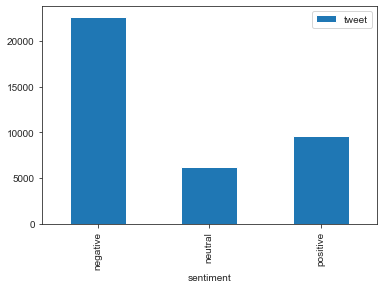

In [115]:
# See how many positive/neutral/negative samples we've got
df[['tweet', 'sentiment']].groupby(['sentiment']).count().plot(kind='bar')
# Make sure the plot doesn't immediately disappear
plt.show(block=True)
# Dataset is unbalanced, skewed towards the negative class:

In [116]:
print("Total tweets: ", len(df))

Total tweets:  38511


In [117]:
# Save all data to file
df.to_csv('twitter_sentiment_analysis.csv')

In [20]:
header_list = ["Name", "Dept", "Start Date"]

tweets140 = pd.read_csv('./training.1600000.processed.noemoticon.csv', encoding='latin-1', names=header_list)

In [21]:
tweets140.head()
df['date'].unique()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


### Training a sentiment classifier: first attempt

In [118]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

data = pd.read_csv('./twitter_sentiment_analysis.csv')

In [119]:
tweets = data['tweet'].values.astype(str)
sentiments = data['sentiment'].values.astype(str)

In [120]:
# Split the data for training and for testing and shuffle it
X_train, X_test, y_train, y_test = train_test_split(tweets, sentiments,
                                                    test_size=0.2, shuffle=True)


In [121]:
from nltk.tokenize.casual import TweetTokenizer
tweet_tokenizer = TweetTokenizer(strip_handles=True)

In [122]:
vectorizer = CountVectorizer(lowercase=True, tokenizer=tweet_tokenizer.tokenize)

# Compute the vocabulary only on the training data
vectorizer.fit(X_train)


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fb51ab43810>>,
                vocabulary=None)

In [123]:
# Transform the text list to a matrix form
X_train_vectorized = vectorizer.transform(X_train)

classifier = MultinomialNB()

In [124]:
# Train the classifier
classifier.fit(X_train_vectorized, y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [125]:
# Vectorize the test data
X_test_vectorized = vectorizer.transform(X_test)

In [126]:
# Check our classifier performance
score = classifier.score(X_test_vectorized, y_test)
print("Accuracy=", score)

Accuracy= 0.7813838764117876


### Fine tunning the model

#### Try a logistic regression classifier

In [127]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

In [128]:
classifier.fit(X_train_vectorized, y_train)
X_test_vectorized = vectorizer.transform(X_test)
score = classifier.score(X_test_vectorized, y_test)
print("Accuracy=", score)
# Accuracy improves with this new model:

Accuracy= 0.8016357263403868


#### Use N-grams instead of words

In [129]:
vectorizer = CountVectorizer(lowercase=True,
                             tokenizer=tweet_tokenizer.tokenize,
                             ngram_range=(1, 3))

In [130]:
vectorizer.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 3), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fb51ab43810>>,
                vocabulary=None)

In [131]:
X_train_vectorized = vectorizer.transform(X_train)
classifier.fit(X_train_vectorized, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [132]:
X_test_vectorized = vectorizer.transform(X_test)
score = classifier.score(X_test_vectorized, y_test)
print("Accuracy=", score)
# Accuracy goes up (!)

Accuracy= 0.8199402830066208


### Build a pipeline

In [133]:
from sklearn.pipeline import Pipeline

tweet_tokenizer = TweetTokenizer(strip_handles=True)

data = pd.read_csv('./twitter_sentiment_analysis.csv')

tweets = data['tweet'].values.astype(str)
sentiments = data['sentiment'].values.astype(str)

# Split the data for training and for testing and shuffle it
X_train, X_test, y_train, y_test = train_test_split(tweets, sentiments,
                                                    test_size=0.2, shuffle=True)

# Put everything in a Pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(
        lowercase=True,
        tokenizer=tweet_tokenizer.tokenize,
        ngram_range=(1, 3))),
    ('classifier', LogisticRegression())
])

# Compute the vocabulary and train the classifier
pipeline.fit(X_train, y_train)

# Check our classifier performance
score = pipeline.score(X_test, y_test)
print("Accuracy=", score)

Accuracy= 0.8182526288459042


### Cross validation

In [134]:
# CV is a workaround for setting aside a validation set from the training and testing data 
# to validate the final model, once all the fine tunning has been made, with data that hasn't 
# been seen to avoid overfitting the model by only using the same testing data all the time.
# This works by splitting the data into N folds so that the system is trained N times
# on all the data, each time excluding a different fold out of the N total ones.
# At the end the scores of all the trainings are averaged.

import pandas as pd
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from nltk.tokenize.casual import TweetTokenizer


tweet_tokenizer = TweetTokenizer(strip_handles=True)

data = pd.read_csv('./twitter_sentiment_analysis.csv')

tweets = data['tweet'].values.astype(str)
sentiments = data['sentiment'].values.astype(str)

# Put everything in a Pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(
        lowercase=True,
        tokenizer=tweet_tokenizer.tokenize,
        ngram_range=(1, 3))),
    ('classifier', LogisticRegression())
    ])

tweets, sentiments = shuffle(tweets, sentiments)
print("MeanAccuracy=", cross_val_score(pipeline, tweets, sentiments, cv=5).mean())

MeanAccuracy= 0.8184294746946772


### Grid search

In [ ]:
# # Grid search allows to optimize parameter combinations by doing cross validation
# # for every possible parameter combination

# from sklearn.model_selection import train_test_split, GridSearchCV

# tweet_tokenizer = TweetTokenizer(strip_handles=True)

# data = pd.read_csv('./twitter_sentiment_analysis.csv')

# tweets = data['tweet'].values.astype(str)
# sentiments = data['sentiment'].values.astype(str)

# # Shuffle the data
# tweets, sentiments = shuffle(tweets, sentiments)

# # Put everything in a Pipeline
# pipeline = Pipeline([
#     ('vectorizer', CountVectorizer(
#         lowercase=True, tokenizer=tweet_tokenizer.tokenize,
#         ngram_range=(1, 3))),
#     ('classifier', LogisticRegression())
# ])

# classifier = GridSearchCV(pipeline, {
#     # try out different ngram ranges
#     'vectorizer__ngram_range': ((1, 2), (2, 3), (1, 3)),
#     # check if setting all non zero counts to 1 makes a difference
#     'vectorizer__binary': (True, False),
# }, n_jobs=-1, verbose=True, error_score=0.0, cv=5)

# # Compute the vocabulary and train the classifier
# classifier.fit(tweets, sentiments)

# print("Best Accuracy: ", classifier.best_score_)
# print("Best Parameters: ", classifier.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


In [137]:
from sklearn.metrics import classification_report
print(classification_report( y_test, classifier.predict(X_test_vectorized)))

              precision    recall  f1-score   support

    negative       0.59      0.64      0.62      4579
     neutral       0.17      0.13      0.14      1251
    positive       0.24      0.23      0.23      1873

    accuracy                           0.46      7703
   macro avg       0.33      0.33      0.33      7703
weighted avg       0.44      0.46      0.45      7703



In [141]:
from sklearn.externals import joblib
joblib.dump(classifier, 'classifier_lr.pkl')

['classifier_lr.pkl']

In [147]:
classifier = joblib.load('classifier_lr.pkl')


In [156]:
tweets_predict = corpus_sent['tweet_clean']
tweets_predict
# vectorizer.fit(tweets_predict)

0         themossadil jobigutenburg guardian go usual retinue bad mouthing israel n usual venom spew baseless accusation israel responsible corrupt pa occup...
1                                                                  friend mine get mederna vaccine last thursday sore arm bad thing work dietary state hospital
2         beschlossdc redtaz trump never care democracy civilization raw power would give vaccine rich friend watch country turn stand stephen king wearamas...
3                                                                 kristie_lauraaa ttamharl never flu vaccine shot inhibit symptom problem miss strain past year
4                                                               tennessee official give covid vaccine close family friend deny year old report https co yhojyou
5                                                              sdr_medco reneeweathers get start take need mandate not get restaurant bar without proof vaccine
6         chizack scripteladora danield 

In [149]:
tweets_predict_vectorized = vectorizer.transform(tweets_predict)

In [159]:
sentiment_predict=classifier.predict(tweets_predict)

ValueError: could not convert string to float: 'themossadil jobigutenburg guardian go usual retinue bad mouthing israel n usual venom spew baseless accusation israel responsible corrupt pa occupier sit pile cash steal international donor rather buy vaccine populace occupy'